# Proving Ginge Wrong About Chess

In [1]:
import pandas as pd
import chess.pgn
import numpy as np

In [17]:
N_GAMES = 1_000_000
MAX_ELO_DELTA = 100

In [2]:
pgn_file = 'lichess_db_standard_rated_2014-07.pgn'
pgn = open(pgn_file)

white_elo = np.empty(shape=(N_GAMES), dtype=float)
black_elo = np.empty(shape=(N_GAMES), dtype=float)
white_points = np.empty(shape=(N_GAMES), dtype=float)
black_points = np.empty(shape=(N_GAMES), dtype=float)


for i in range(N_GAMES):
    
    try:
        game = chess.pgn.read_game(pgn)

        white_elo[i] = game.headers['WhiteElo'].replace('?', '')
        black_elo[i] = game.headers['BlackElo'].replace('?', '')

        if game.headers['Result'] == '1-0':
            white_points[i] = 1.0
        elif game.headers['Result'] == '0-1':
            white_points[i] = 0.0
        elif game.headers['Result'] == '1/2-1/2':
            white_points[i] = 0.5
        else:
            raise RuntimeError(f'Unrecognized result: {game.headers["Result"]}')
        
        black_points[i] = 1 - white_points[i]

    except Exception:
        white_elo[i] = 0
        black_elo[i] = 0
        white_points[i] = 0
        black_points[i] = 0

In [3]:
data = pd.DataFrame(data=[white_elo, black_elo, white_points, black_points]).T
data.columns = ['white_elo', 'black_elo', 'white_points', 'black_points']

In [4]:
data['delta_elo'] = data['white_elo'].sub(data['black_elo']).abs()
data.to_csv(f'{pgn_file}.df', mode='w')

In [9]:
data[(data['delta_elo'] < MAX_ELO_DELTA) & (data['white_elo'] != 0)].agg(['mean', 'std', 'count'])

,white_elo,black_elo,white_points,black_points,delta_elo
mean,1625.276286,1624.413862,0.515843,0.484157,46.795980
std,202.006251,202.340182,0.489281,0.489281,28.399201
count,454789.000000,454789.000000,454789.000000,454789.000000,454789.000000


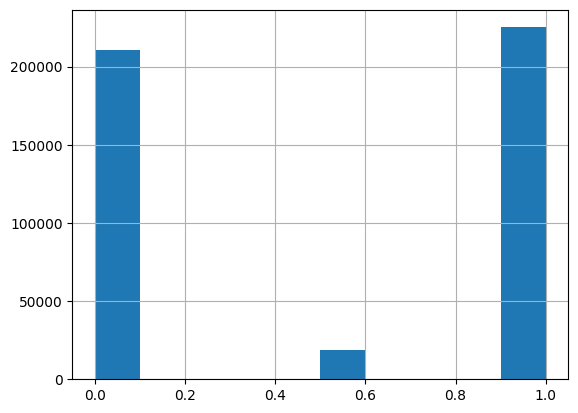

In [18]:
hist = data[(data['delta_elo'] < MAX_ELO_DELTA) & (data['white_elo'] != 0)]['white_points'].hist()

In [20]:
white_wins = data[(data['delta_elo']<100) & (data['white_elo'] != 0) & (data['white_points'] == 1)].count()[0]
draws = data[(data['delta_elo']<100) & (data['white_elo'] != 0) & (data['white_points'] == 0.5)].count()[0]
black_wins = data[(data['delta_elo']<100) & (data['white_elo'] != 0) & (data['black_points'] == 1)].count()[0]
total = white_wins + draws + black_wins

In [27]:
print(
    f'''
    Out of {N_GAMES:,} games played on lichess.org, {total:,} games were played between players with an Elo within {MAX_ELO_DELTA} points.
    
    White won {white_wins:,} of those games.
    Black won {black_wins:,} of those games.
    And {draws:,} of those games were drawn.

    White had an apparent advantage of {white_wins/black_wins:.3f} to 1.
    '''
)


    Out of 1,000,000 games played on lichess.org, 85,364 games were played between players with an Elo within 100 points.
    
    White won 42,880 of those games.
    Black won 38,030 of those games.
    And 4,454 of those games were drawn.

    White had an apparent advantage of 1.128 to 1.
    


In [26]:
# Repeat the above analysis for high rated players only
MIN_RATING = 1800
white_wins = data[(data['delta_elo']<100) & (data['white_elo'] > MIN_RATING) & (data['white_points'] == 1)].count()[0]
draws = data[(data['delta_elo']<100) & (data['white_elo'] > MIN_RATING) & (data['white_points'] == 0.5)].count()[0]
black_wins = data[(data['delta_elo']<100) & (data['white_elo'] > MIN_RATING) & (data['black_points'] == 1)].count()[0]
total = white_wins + draws + black_wins

print(
    f'''
    Out of {N_GAMES:,} games played on lichess.org, {total:,} games were played between players with an Elo within {MAX_ELO_DELTA} points and a rating above {MIN_RATING}.
    
    White won {white_wins:,} of those games.
    Black won {black_wins:,} of those games.
    And {draws:,} of those games were drawn.

    White had an apparent advantage of {white_wins/black_wins:.3f} to 1.
    '''
)


    Out of 1,000,000 games played on lichess.org, 85,364 games were played between players with an Elo within 100 points and a rating above 1800.
    
    White won 42,880 of those games.
    Black won 38,030 of those games.
    And 4,454 of those games were drawn.

    White had an apparent advantage of 1.128 to 1.
    
